In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from keras.models import Model
from keras.layers import Dense, Input, add, BatchNormalization, concatenate, Embedding, Flatten 
from tensorflow.keras.optimizers import Nadam
from keras.layers.core import Dropout, Activation
from keras.initializers import RandomNormal, Ones

import tensorflow as tf

import seaborn as sns

import random
from numpy import array
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Function PD: Calculate Poisson Deviance
def PD_function(pred, obs):
    PD = 200*( sum(pred) - sum(obs) + sum( np.log( (obs/pred)**(obs) ) ) )
    return PD/len(pred)
    
# evaluate a single mlp model
def evaluate_model(trainX, trainy, train_expo, trainbrand, trainregion,
                   activ_fonction_0, activ_fonction_1, activ_fonction_2,
                   nb_neurones_0, nb_neurones_1, nb_neurones_2, 
                   drop_out_1, drop_out_2
                  ):
    
    first_input = Input(shape=(7))
    
    
    brand_input = Input(shape=(1))
    region_input = Input(shape=(1))    
    
    
    Embedding_brand = Flatten()(Embedding(input_dim = 11, output_dim = 2)(brand_input))
    Embedding_region = Flatten()(Embedding(input_dim = 22, output_dim = 2)(region_input))
    
    
    merge_one_ = tf.keras.layers.Concatenate()([Embedding_brand, Embedding_region, first_input])

    #first_dense_0 = Dense(40)(merge_one_)
    #act_dense_0 = Activation(activ_fonction_0)(first_dense_0)
    
    #first_dense_0 = Dense(nb_neurones_0)(act_dense_0)
    #act_dense_0 = Activation(activ_fonction_0)(first_dense_0)
    
    first_dense_1 = Dense(nb_neurones_1)(merge_one_)
    act_dense_1 = Activation(activ_fonction_1)(first_dense_1)
    
    first_dense_2 = Dense(nb_neurones_2)(act_dense_1)
    act_dense_2 = Activation(activ_fonction_2)(first_dense_2)

    first_dense_3 = Dense(1, 
                          bias_initializer=tf.keras.initializers.Constant(value=-1.7942), 
                          #kernel_initializer=tf.keras.initializers.Ones()
                         )(act_dense_2)
    act_dense_3 = Activation('linear')(first_dense_3)

    second_input = Input(shape=(1, ))

    second_dense_1 = Dense(1, 
                           bias_initializer=tf.keras.initializers.Constant(value=-1.66), 
                           kernel_initializer=tf.keras.initializers.Constant(value=0.43), 
                           trainable=True)(add([act_dense_3, second_input])) 
    final_output = Activation('exponential')(second_dense_1) 

    model_ = Model(inputs=[first_input, second_input, brand_input, region_input], outputs=final_output)

    model_.compile(optimizer=Nadam(), loss='poisson')
    
    callback =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)
    
    history = model_.fit([trainX, train_expo, trainbrand, trainregion], trainy, epochs=450, 
                         verbose=0, validation_split=0.15, batch_size=10000, callbacks=[callback])

    #preds = model_.predict([testX, test_expo, testbrand, testregion]).flatten()  

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return history, model_

In [3]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, X_test, expo_test, brand_test, region_test):
    
    # make predictions
    yhats = [model.predict([X_test, expo_test, brand_test, region_test]) for model in members]
    yhats = array(yhats)
    
    result = np.mean(yhats, axis=0).flatten() 
    
    return result


# evaluate a specific number of members in an ensemble
def evaluate_n_members_bis(members, testX, testexpo, testbrand, testregion):
    
    # select a subset of members
    subset = members[:len(members)]
    
    # make prediction
    yhat = ensemble_predictions(subset, testX, testexpo, testbrand, testregion)
    
    # calculate accuracy 
    return yhat


def Ensemble_fit(Xtrain_, ytrain_, expotrain_, brandtrain_, regiontrain_,
                 samples=30, rate_OOB=0.2, type_ = "Bagging", ver_freq_train=True):
    
    scores_, members_ = list(), list()
    
    activ_fonction_0, activ_fonction_1, activ_fonction_2 = random.sample(["sigmoid"], 1), random.sample(["sigmoid"], 1), random.sample(["sigmoid"], 1)
    nb_neurones_0, nb_neurones_1, nb_neurones_2 = random.sample([25], 1), random.sample([15], 1), random.sample([10], 1)
    drop_out_1, drop_out_2 = random.sample([0.02, 0.04, 0.06, 0.08], 1), random.sample([0.02, 0.04, 0.06, 0.08], 1)
        
    # evaluate model
    model, model_fit = evaluate_model(Xtrain_, ytrain_, expotrain_, brandtrain_, regiontrain_, 
                                         activ_fonction_0[0], activ_fonction_1[0], activ_fonction_2[0], 
                                         nb_neurones_0[0], nb_neurones_1[0], nb_neurones_2[0], 
                                         drop_out_1[0], drop_out_2[0])
    
    members_.append(model_fit)   
    
    return members_

, 81, 37 ,71, 28, 70, 54, 59, 17, 79

62


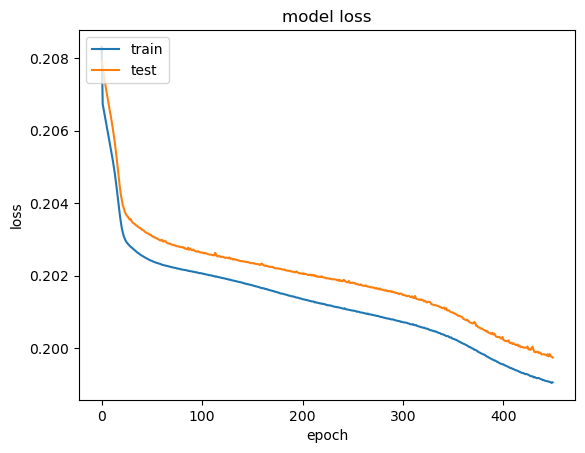

18878/18878 [==============================] - 19s 988us/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573735      7      0      0      0]
 [ 28667      3      0      0      0]
 [  1587      2      1      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64389     4     0     0     0]
 [ 3217     1     0     0     0]
 [  176     2     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


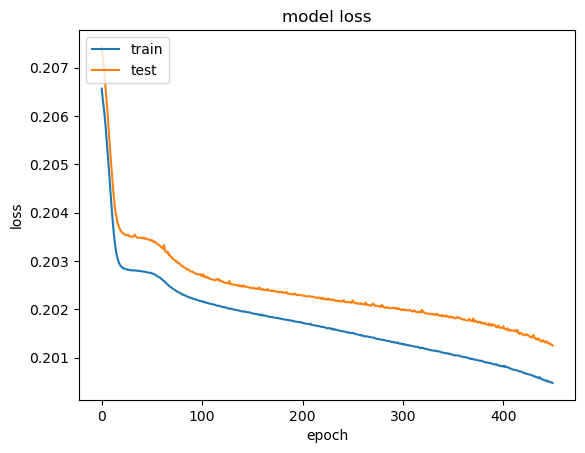

18878/18878 [==============================] - 21s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573691     51      0      0      0]
 [ 28638     32      0      0      0]
 [  1583      7      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64388     5     0     0     0]
 [ 3216     2     0     0     0]
 [  174     4     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


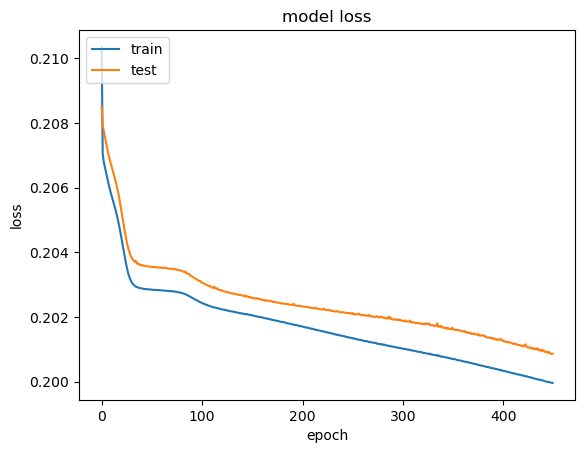

18878/18878 [==============================] - 20s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573716     26      0      0      0]
 [ 28653     17      0      0      0]
 [  1586      4      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64389     4     0     0     0]
 [ 3218     0     0     0     0]
 [  175     3     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


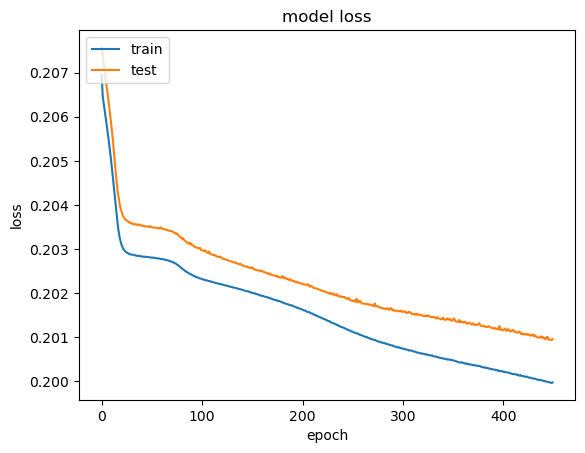

18878/18878 [==============================] - 19s 990us/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573689     53      0      0      0]
 [ 28641     29      0      0      0]
 [  1584      6      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64390     3     0     0     0]
 [ 3215     3     0     0     0]
 [  176     2     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


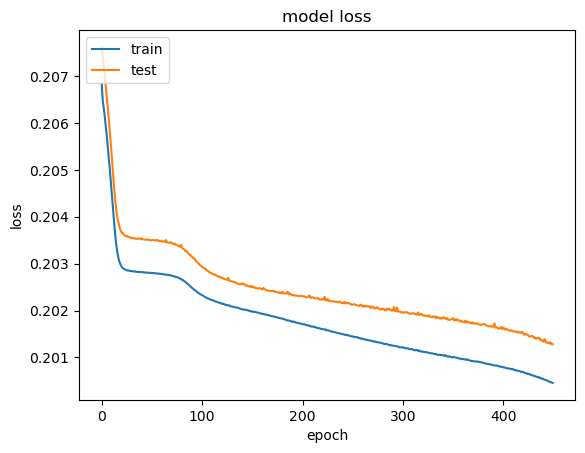

18878/18878 [==============================] - 23s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573681     61      0      0      0]
 [ 28632     38      0      0      0]
 [  1584      6      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64388     5     0     0     0]
 [ 3214     4     0     0     0]
 [  174     4     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


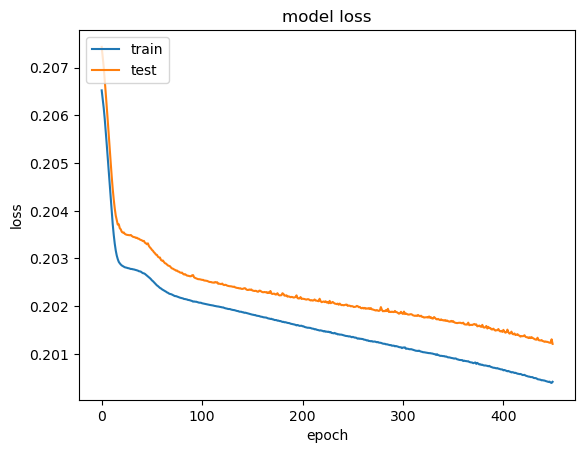

18878/18878 [==============================] - 21s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573686     56      0      0      0]
 [ 28633     37      0      0      0]
 [  1583      7      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64385     8     0     0     0]
 [ 3214     4     0     0     0]
 [  175     3     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


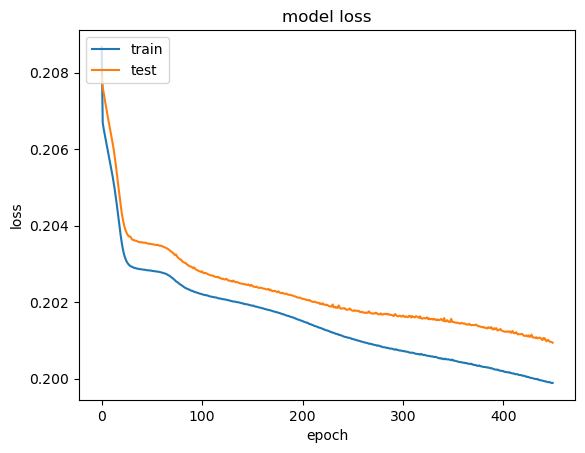

18878/18878 [==============================] - 20s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573699     43      0      0      0]
 [ 28649     21      0      0      0]
 [  1584      6      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64388     5     0     0     0]
 [ 3215     3     0     0     0]
 [  175     3     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


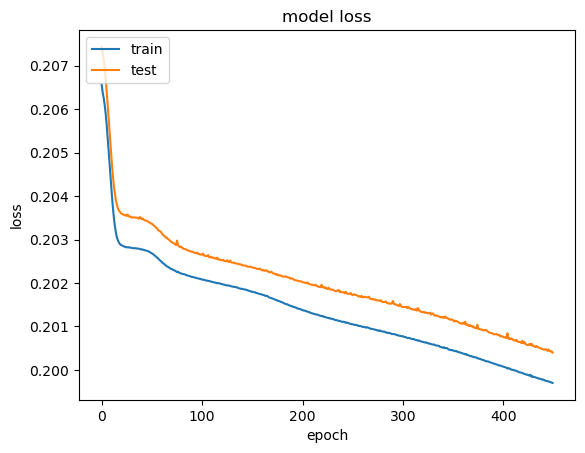

18878/18878 [==============================] - 21s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573697     45      0      0      0]
 [ 28638     32      0      0      0]
 [  1583      7      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64387     6     0     0     0]
 [ 3214     4     0     0     0]
 [  176     2     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


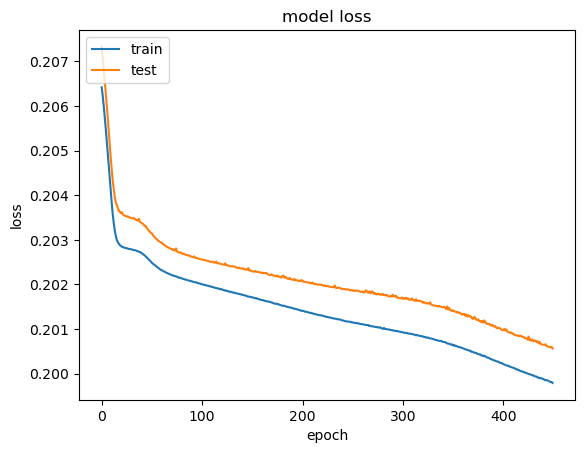

18878/18878 [==============================] - 21s 1ms/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573722     20      0      0      0]
 [ 28650     20      0      0      0]
 [  1585      5      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64390     3     0     0     0]
 [ 3215     3     0     0     0]
 [  176     2     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]
62


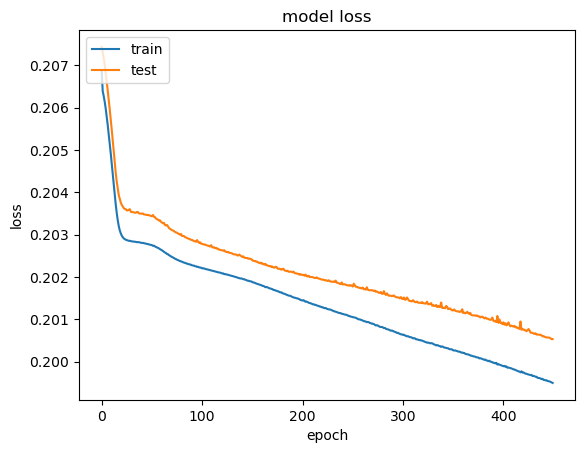

18878/18878 [==============================] - 18s 955us/step


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_1124\2531931369.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson = df_poisson.append(cnt, ignore_index=True)


[[573646     96      0      0      0]
 [ 28619     51      0      0      0]
 [  1574     16      0      0      0]
 [    73      0      0      0      0]
 [    14      0      0      0      0]]
[[64385     8     0     0     0]
 [ 3212     6     0     0     0]
 [  175     3     0     0     0]
 [    8     0     0     0     0]
 [    2     0     0     0     0]]


In [4]:
df_poisson = pd.DataFrame()
df_matrix_train_ = 0
df_matrix_valid_ = 0


table_name = ["deviance_train", "deviance_test", "diff_train", "diff_test"]

for p in [62]*10:
    
    print(p)
    
    data_learn = pd.read_csv(r'C:\Users\KRASNIQ\Documents\These_1.1\data\data_learn_'+str(62)+'.csv')
    data_test = pd.read_csv(r'C:\Users\KRASNIQ\Documents\These_1.1\data\data_test_'+str(62)+'.csv')
    
    nex_data = pd.concat([data_learn, data_test])
    
    data_learn_, data_test_ = train_test_split(nex_data, stratify=nex_data['ClaimNb'], test_size=0.1, random_state=p)
    
    data_learn_['Exposure'] = data_learn_['Exposure'].clip(upper=1)
    data_test_['Exposure'] = data_test_['Exposure'].clip(upper=1)
    
    data_learn_['Area'] = data_learn_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    data_test_['Area'] = data_test_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    
    data_learn_ = data_learn_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                    "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                    'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                    'VehAge', 'VehGas', "VehGas_class_2"], axis=1)

    data_test_ = data_test_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                  "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                  'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                  'VehAge', 'VehGas', "VehGas_class_2"], axis=1)
    
    # train test split 
    X_train__, X_valid__ = train_test_split(data_learn_, stratify=data_learn_['ClaimNb'], test_size=0.01, random_state=p)
    
    
    #################### label encoding
    
    le_region = preprocessing.LabelEncoder()
    le_region.fit(X_train__['Region'])

    le_brand = preprocessing.LabelEncoder()
    le_brand.fit(X_train__['VehBrand'])
    
    y_train = np.array(X_train__.filter(['ClaimNb']))
    log_exp_train= np.array(np.log(X_train__.filter(['Exposure'])))
    region_train = np.array(le_region.transform(X_train__['Region']))
    brand_train = np.array(le_brand.transform(X_train__['VehBrand']))
    x_train = X_train__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])

    y_valid = np.array(X_valid__.filter(['ClaimNb']))
    log_exp_valid= np.array(np.log(X_valid__.filter(['Exposure'])))
    region_valid = np.array(le_region.transform(X_valid__['Region']))
    brand_valid = np.array(le_brand.transform(X_valid__['VehBrand']))
    x_valid = X_valid__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #valid
    y_test = np.array(data_test_.filter(['ClaimNb']))
    log_exp_test = np.array(np.log(data_test_.filter(['Exposure'])))
    region_test = np.array(le_region.transform(data_test_['Region']))
    brand_test = np.array(le_brand.transform(data_test_['VehBrand']))
    x_test = data_test_.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #feature eng
    cs = MinMaxScaler()
    X_train = np.array(2*((x_train - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_valid = np.array(2*((x_valid - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_test = np.array(2*((x_test - x_train.min())/(x_train.max()-x_train.min())) - 1)
    
    
    members = Ensemble_fit(X_train, y_train, log_exp_train, brand_train, region_train,
                                   samples=1, rate_OOB=0, type_ = "Bagging",
                                   ver_freq_train=False)

    
    predictions_test = evaluate_n_members_bis(members, X_test, log_exp_test, brand_test, region_test)
    predictions_train = evaluate_n_members_bis(members, X_train, log_exp_train, brand_train, region_train)

    #deviance
    table_modal= [np.round(PD_function(predictions_train, y_train.flatten()),6),
                  np.round(PD_function(predictions_test, y_test.flatten()),6),
                  (sum(predictions_train) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test) -sum(y_test.flatten()))/sum(y_test.flatten())*100]
    
    table_name = ["deviance_train", "deviance_test", "diff_train", "diff_test"]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson = df_poisson.append(cnt, ignore_index=True)
    


    cf_matrix_train = confusion_matrix(y_train, np.round(predictions_train).astype(int))
    print(cf_matrix_train)

    if cf_matrix_train.shape[0] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[1]], axis=0)

    if cf_matrix_train.shape[1] == 2:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 3:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)
    if cf_matrix_train.shape[1] == 4:
        cf_matrix_train = np.append(cf_matrix_train, [[0]*cf_matrix_train.shape[0]], axis=1)

    df_matrix_train_ = df_matrix_train_ + cf_matrix_train

    cf_matrix_valid = confusion_matrix(y_test, np.round(predictions_test).astype(int))
    print(cf_matrix_valid)

    if cf_matrix_valid.shape[0] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, [[0]*cf_matrix_valid.shape[1]], axis=0)

    if cf_matrix_valid.shape[1] == 2:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 3:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)
    if cf_matrix_valid.shape[1] == 4:
        cf_matrix_valid = np.append(cf_matrix_valid, np.zeros((cf_matrix_valid.shape[0],1)), axis=1)

    df_matrix_valid_ = df_matrix_valid_ + cf_matrix_valid

In [5]:
df_poisson['model']=["cv-bagging-1"]*len(df_poisson)

In [6]:
df_poisson

,deviance_train,deviance_test,diff_train,diff_test,model
0,30.023258,30.120231,0.085849,0.076277,cv-bagging-1
1,30.311828,30.415697,-0.016020,0.005086,cv-bagging-1
2,30.212756,30.348945,-1.026696,-0.976418,cv-bagging-1
3,30.219236,30.354128,-3.223323,-3.313341,cv-bagging-1
4,30.314320,30.411725,-2.632546,-2.603169,cv-bagging-1
5,30.297706,30.412337,1.055586,1.074002,cv-bagging-1
6,30.202782,30.332734,-0.046675,0.006806,cv-bagging-1
7,30.156566,30.243324,1.075766,1.079348,cv-bagging-1
8,30.177519,30.298303,0.242276,0.227953,cv-bagging-1
9,30.125378,30.276064,-0.580563,-0.578925,cv-bagging-1


In [7]:
df_poisson["deviance_train"].mean(), df_poisson["deviance_test"].mean(), df_poisson["diff_train"].mean(), df_poisson["diff_test"].mean()

(30.204134900000003, 30.3213488, -0.5066344995614039, -0.5002382154215805)

In [8]:
df_poisson["deviance_train"].std(), df_poisson["deviance_test"].std(), df_poisson["diff_train"].std(), df_poisson["diff_test"].std()

(0.091097393767391,
 0.09215446139534787,
 1.4331206851698006,
 1.4497973688964885)